## Initial Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import numpy as np
import netCDF4
from netCDF4 import Dataset
from tempfile import TemporaryFile

## Load Data

In [ ]:
path='/content/drive/MyDrive/UMBC/iHARP/Data/'
file=path+'ERA5_hourly_geop_500mb_1979_2021.nc'
df=Dataset(file,'r')
data = np.array(df)

## Reading Data from Variables

In [ ]:
print(df.variables.keys()) # get all variable names

dict_keys(['longitude', 'latitude', 'time', 'z'])


## Data Analysis

In [ ]:
#'latitude', 'longitude', 'z', 'time'
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime

class ERA5_data(object):
    def __init__(self,fn):
        import netCDF4 as nc
        nc_fid = nc.Dataset(fn,'r')
        nc_fid.set_auto_mask(False)
        self.t0   = datetime.datetime(1979,1,1)
        self.time = nc_fid.variables['time'][:]
        hours = []
        for t in self.time:
            hours.append(self.t0 +  datetime.timedelta(float(t)))
        self.hours = hours
        self.lon  = nc_fid.variables['longitude'][:] #* units(?)
        self.lat  = nc_fid.variables['latitude'][:] #* units(?)
        self.z = nc_fid.variables['z'][:]
        fill = nc_fid.variables['z'].missing_value
        self.z[np.where(data==fill)]=np.nan

        nc_fid.close()

In [ ]:
ERA5 = ERA5_data('/content/drive/MyDrive/UMBC/iHARP/Data/ERA5_hourly_geop_500mb_1979_2021.nc')

Task: Read every day's dataset and compare with next day

In [ ]:
print('number of hours:', len(ERA5.hours))
print('number of latitude points:', len(ERA5.lat))
print('number of longitude points:', len(ERA5.lon))
print('dimensions of the data',ERA5.z.shape)

number of hours: 31412
number of latitude points: 21
number of longitude points: 61
dimensions of the data (31412, 21, 61)


### Calculating Geopotential Height from Geopotential

In [ ]:
# Dividing geopotential by constant of gravity

geop_h = ERA5.z / 9.80665
print('dimensions of the data',geop_h.shape)
print(ERA5.z[1,10,11])
print(ERA5.z[1,11,12])
print(ERA5.z[1000,10,11])
print(ERA5.z[1000,11,12])
print(geop_h[1,10,11])
print(geop_h[1,11,12])
print(geop_h[1000,10,11])
print(geop_h[1000,11,12])

dimensions of the data (31412, 21, 61)
50664.95589197428
50789.091636560974
52304.44607130186
52410.81897085724
5166.387695285778
5179.046018422293
5333.569166973622
5344.41618400343


## Calculating the Z-Height
Geopotential * Gravitational Constant (9.80665)

Run either Z-Height or Geopotential Height according to the need.

In [ ]:
z_h = ERA5.z * 9.80665
print('dimensions of the data',z_h.shape)

dimensions of the data (31412, 21, 61)


In [ ]:
31412/15706 #12 hourly data for 15706 days. 2 data entries for every day

2.0

### Calculating GBI
Dr Lenaerts: "the normalised area-weighted 500 hPa geopotential height over the region 60–80° N, 20–80° W"


[NOAA Calculation Method](https://psl.noaa.gov/data/timeseries/daily/GBI/):
500mb geopotential height area averaged 60-80N, 280-340E from the daily averaged NCEP/NCAR Reanalysis


In [ ]:
def weighted_mean(data):
#calculate weighted average of data
    lon_mean=np.nanmean(data,axis=1) #average along longitude
    #print('lon_mean',lon_mean)
    #print('lon_mean.shape',lon_mean.shape)
    weight=np.cos(np.deg2rad(ERA5.lat))
    #print('weight.shape',weight.shape)
    results=np.average(lon_mean,weights=weight)
    return results

In [ ]:
#weighted_time_series =  np.array([weighted_mean(z_h[i,:,:]) for i in range(0,len(ERA5.hours))])
weighted_time_series =  np.array([weighted_mean(geop_h[i,:,:]) for i in range(0,len(ERA5.hours))])
#weighted_time_series =  np.array([weighted_mean(geop_h[i,:,:]) for i in range(0,10)])
#weighted_time_series =  np.array([weighted_mean(geop_h[i,:,:]) for i in range(200,210)])

In [ ]:
days = 15706
daily_time_series = np.array([np.mean(weighted_time_series[i:i+2]) for i in range(days)])

In [ ]:
print(weighted_time_series.shape)
print(daily_time_series.shape)

(31412,)
(15706,)


Text(0, 0.5, 'Greenland Blocking Index')

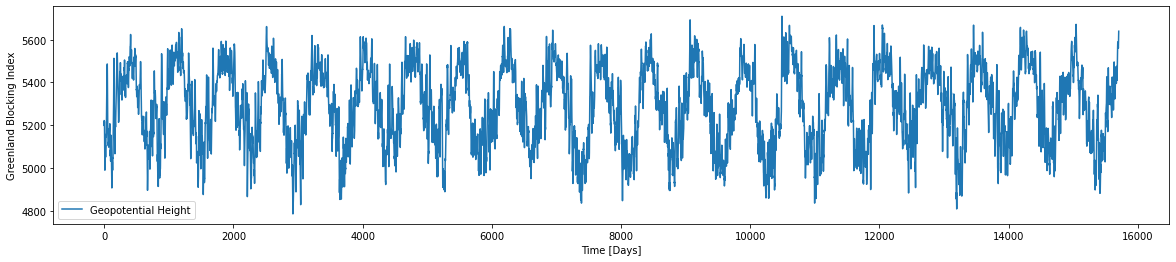

In [ ]:
fig,ax = plt.subplots(figsize = [20,4])
ax.plot(range(days),daily_time_series, label = "Geopotential Height")
ax.legend()
ax.set_xlabel("Time [Days]")
ax.set_ylabel(r"Greenland Blocking Index")

Text(0, 0.5, 'Z-height')

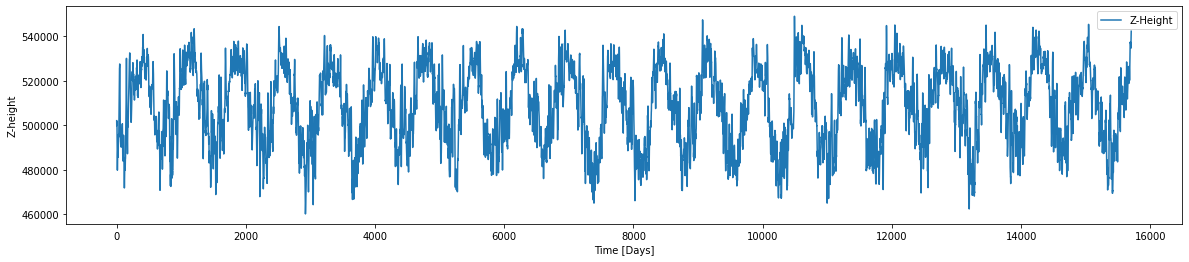

In [ ]:
fig,ax = plt.subplots(figsize = [20,4])
ax.plot(range(days),daily_time_series, label = "Z-Height")
ax.legend()
ax.set_xlabel("Time [Days]")
ax.set_ylabel(r"Z-height")

In [ ]:
#np.save('/content/drive/MyDrive/UMBC/iHARP/Data/Daily_GBI_1979_2021.npy',daily_time_series)
np.save('/content/drive/MyDrive/UMBC/iHARP/Data/Daily_GBI_1979_2021.npy',daily_time_series)

### Calculating GBI Daily Mean

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd

gbi_df = pd.read_csv('/content/drive/MyDrive/UMBC/iHARP/Data/GBI_daily_1979_2018.csv')
gbi_df = gbi_df.drop(columns=['Date'],axis = 1)
print(gbi_df.info())
gbi = np.array(gbi_df)
print(gbi.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14600 entries, 0 to 14599
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GBI     14600 non-null  float64
dtypes: float64(1)
memory usage: 114.2 KB
None
(14600, 1)


In [ ]:
#reshaping GBI into Year x Days -> gbi[0,:] will give 365 values for 1979
gbi = gbi.reshape(int(gbi.shape[0]/365),365)
print(gbi.shape)
#taking mean for each day for 40 years
gbi_daily_mean = np.mean(gbi, axis = 0)
print(gbi_daily_mean.shape)

In [ ]:
#reshaping GBI into Year x Days -> gbi[0,:] will give 365 values for 1979
gbi = gbi.reshape(int(gbi.shape[0]/365),365)
print(gbi.shape)
#taking std for each day for 40 years
gbi_daily_std = np.std(gbi, axis = 0)
print(gbi_daily_std.shape)

(40, 365)
(365,)


In [ ]:
#Calculating STD based on daily annual average
gbi_daily_mean = np.array(pd.read_csv('/content/drive/MyDrive/UMBC/iHARP/Data/GBI_daily_mean_1979_2018.csv'))

gbi_test = np.copy(gbi_daily_mean)
print(gbi_test.shape)
#taking std for each day for 40 years
gbi_mean = np.mean(gbi_daily_mean, axis = 0)
gbi_daily_std = gbi_test - gbi_mean
gbi_daily_std = gbi_daily_std.reshape(365)
print(gbi_daily_std.shape)

In [ ]:
dict={'GBI_STD':gbi_daily_std}
data=pd.DataFrame(dict)
data.to_csv('/content/drive/MyDrive/UMBC/iHARP/Data/GBI_daily_std_1979_2018.csv',header=True,index=False)

In [ ]:
dict={'GBI':gbi_daily_mean}
data=pd.DataFrame(dict)
data.to_csv('/content/drive/MyDrive/UMBC/iHARP/Data/GBI_daily_mean_1979_2018.csv',header=True,index=False)

Plotting Geopotential, GBI and GBI_daily_mean

In [ ]:
import pandas as pd
gbi_daily = np.array(pd.read_csv('/content/drive/MyDrive/UMBC/iHARP/Data/GBI_daily_1979_2018.csv'))
gbi_daily_avg = np.array(pd.read_csv('/content/drive/MyDrive/UMBC/iHARP/Data/GBI_daily_mean_1979_2018.csv'))
print(gbi_daily.shape)
print(gbi_daily_avg.shape)

(14600, 2)
(365, 1)


Plotting the Trend

Text(0, 0.5, 'Greenland Blocking Index 40 Year Avg')

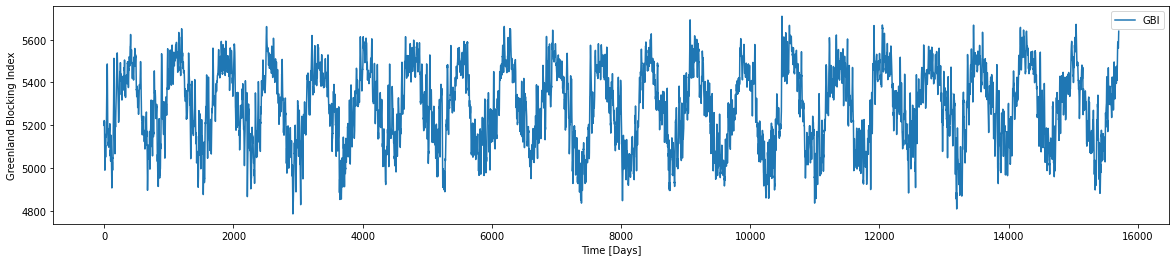

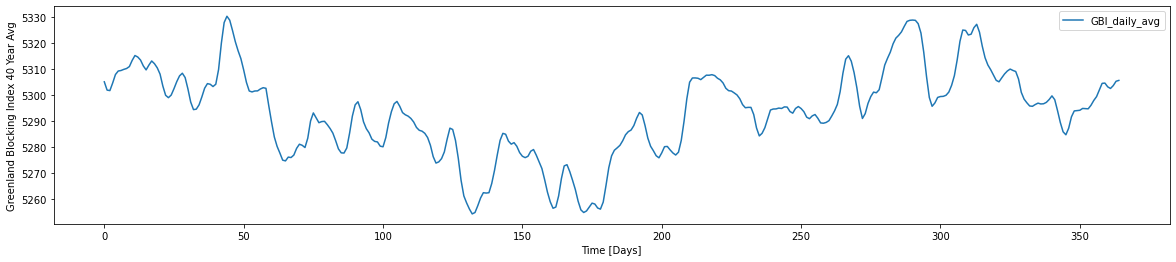

In [ ]:
fig,ax = plt.subplots(figsize = [20,4])
ax.plot(range(days),daily_time_series, label = "GBI")
ax.legend()
ax.set_xlabel("Time [Days]")
ax.set_ylabel(r"Greenland Blocking Index")

fig,ax = plt.subplots(figsize = [20,4])
ax.plot(range(365),gbi_daily_avg, label = "GBI_daily_avg")
ax.legend()
ax.set_xlabel("Time [Days]")
ax.set_ylabel(r"Greenland Blocking Index 40 Year Avg")

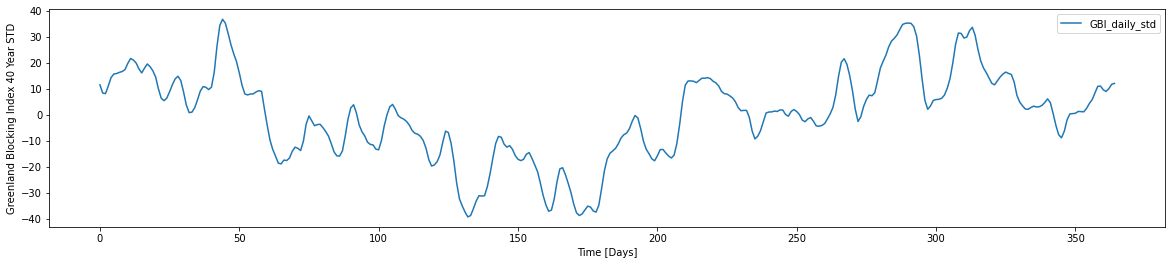

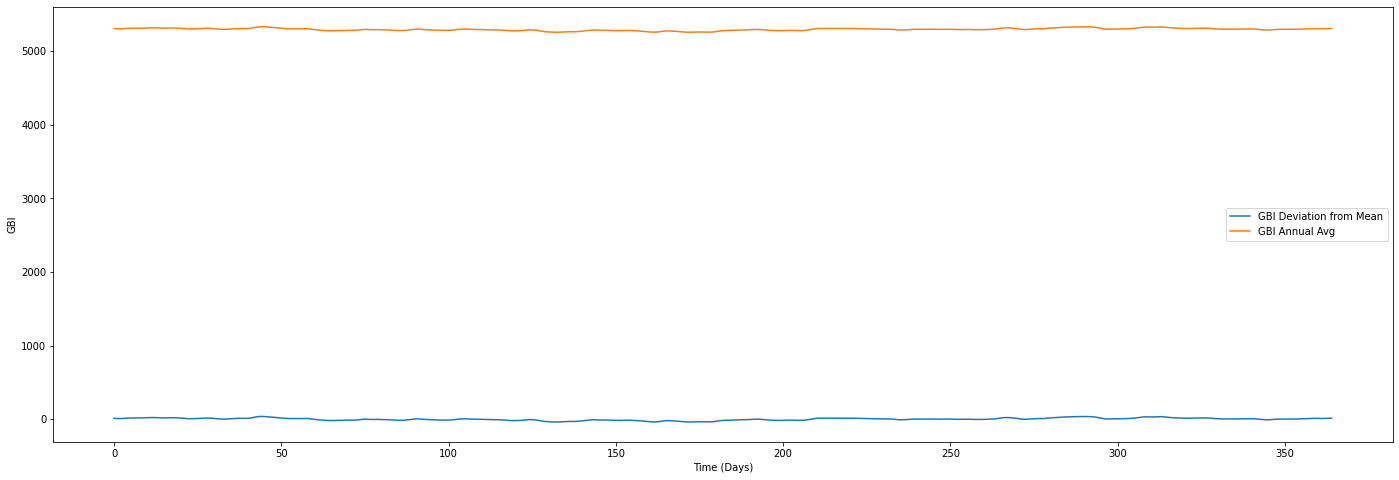

In [ ]:
#Plotting Daily Mean vs STD
fig,ax = plt.subplots(figsize = [20,4])
ax.plot(range(365),gbi_daily_std, label = "GBI_daily_std")
ax.legend()
ax.set_xlabel("Time [Days]")
ax.set_ylabel(r"Greenland Blocking Index 40 Year STD")

from matplotlib import pyplot

fig, ax= plt.subplots(figsize=(24, 8))
pyplot.plot(gbi_daily_std)
pyplot.plot(gbi_daily_mean)
#pyplot.plot(inv_y1_pred-inv_y0_pred)
plt.legend (['GBI Deviation from Mean','GBI Annual Avg'])
#plt.legend (['y_obs','y_gbi_max'])
#plt.title("SIE Prediction (2017-18) for GBI Daily Average of 40 years")
ax.set_xlabel("Time (Days)")
ax.set_ylabel(r"GBI")
pyplot.show()
#fig.savefig('SIE_ArcOcean_GBI_daily_avg.png')

Text(0, 0.5, 'Greenland Blocking Index')

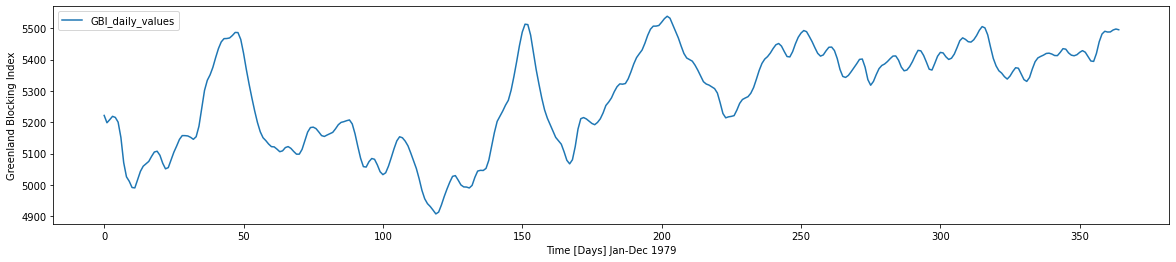

In [ ]:
#Plotting just one year of data
import pandas as pd
gbi_daily = np.array(pd.read_csv('/content/drive/MyDrive/UMBC/iHARP/Data/GBI_daily_1979_2018.csv'))

fig,ax = plt.subplots(figsize = [20,4])
ax.plot(range(365),gbi_daily[:365,-1], label = "GBI_daily_values")
ax.legend()
ax.set_xlabel("Time [Days] Jan-Dec 1979")
ax.set_ylabel(r"Greenland Blocking Index")

### GBI Daily Trend for first 23 Years

In [ ]:
#Plotting just one year of data
import pandas as pd
gbi_daily = np.array(pd.read_csv('/content/drive/MyDrive/UMBC/iHARP/Data/GBI_daily_1979_2018.csv'))

j = 0
summer_days = gbi_daily[151:243,:]
print(summer_days.shape)
for i in range(1979,2002):
  if i % 4 == 0:
    year_data = gbi_daily[j:j+366,:]
    summer = year_data[152:244,:]
    summer_days = np.concatenate((summer_days,summer),axis = 0)
    j = j + 366
    #print(summer.shape)
    #print(summer_days.shape)
  else:
    year_data = gbi_daily[j:j+365,:]
    summer = year_data[151:243,:]
    summer_days = np.concatenate((summer_days,summer),axis = 0)
    j = j + 365

summer_days = summer_days[92:,:]
print('First 23 years summer days:',summer_days.shape)

(92, 2)
First 23 years summer days: (2116, 2)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

X = np.arange(1,2117,1)
Y = summer_days[:,-1]
lr = LinearRegression()
fit = lr.fit(X.reshape(-1, 1), Y)

## coefficients of linear fit are:
b = fit.intercept_
m = fit.coef_

print("the equation of the linear fit is: ")
print('y= ', m, 'x + ', b)

# checking R^2
R_sqd = lr.score(X.reshape(-1, 1), Y.reshape(-1, 1))
print("lr confidence: ", R_sqd)

the equation of the linear fit is: 
y=  [-0.03548289] x +  5310.0139053466655
lr confidence:  0.032340536934510555


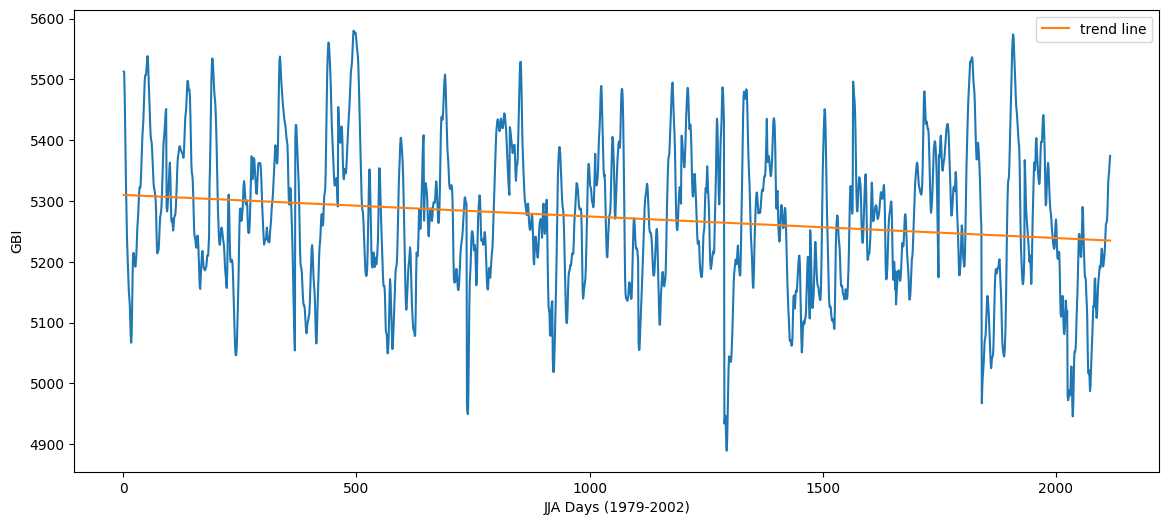

In [ ]:
plt.rcParams["figure.figsize"] = (14,6)
plt.plot(X, Y)
plt.xlabel('JJA Days (1979-2002)')
plt.ylabel('GBI')
plt.plot(X, lr.predict(X.reshape(-1,1)), label='trend line')
plt.legend()

### GBI Daily Trend for last 20 Years

In [ ]:
#Plotting just one year of data
import pandas as pd
gbi_daily_2 = gbi_daily[8766:,:]

j = 0
summer_days = gbi_daily_2[151:243,:]
print(summer_days.shape)
for i in range(2003,2018):
  if i % 4 == 0:
    year_data = gbi_daily_2[j:j+366,:]
    summer = year_data[152:244,:]
    summer_days = np.concatenate((summer_days,summer),axis = 0)
    j = j + 366
    #print(summer.shape)
    #print(summer_days.shape)
  else:
    year_data = gbi_daily_2[j:j+365,:]
    summer = year_data[151:243,:]
    summer_days = np.concatenate((summer_days,summer),axis = 0)
    j = j + 365

summer_days = summer_days[92:,:]
print('Last 17 years summer days:',summer_days.shape)

(92, 2)
Last 17 years summer days: (1380, 2)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

X = np.arange(1,1381,1)
Y = summer_days[:,-1]
lr = LinearRegression()
fit = lr.fit(X.reshape(-1, 1), Y)

## coefficients of linear fit are:
b = fit.intercept_
m = fit.coef_

print("the equation of the linear fit is: ")
print('y= ', m, 'x + ', b)

# checking R^2
R_sqd = lr.score(X.reshape(-1, 1), Y.reshape(-1, 1))
print("lr confidence: ", R_sqd)

the equation of the linear fit is: 
y=  [0.0395558] x +  5267.710064543622
lr confidence:  0.01922233649220828


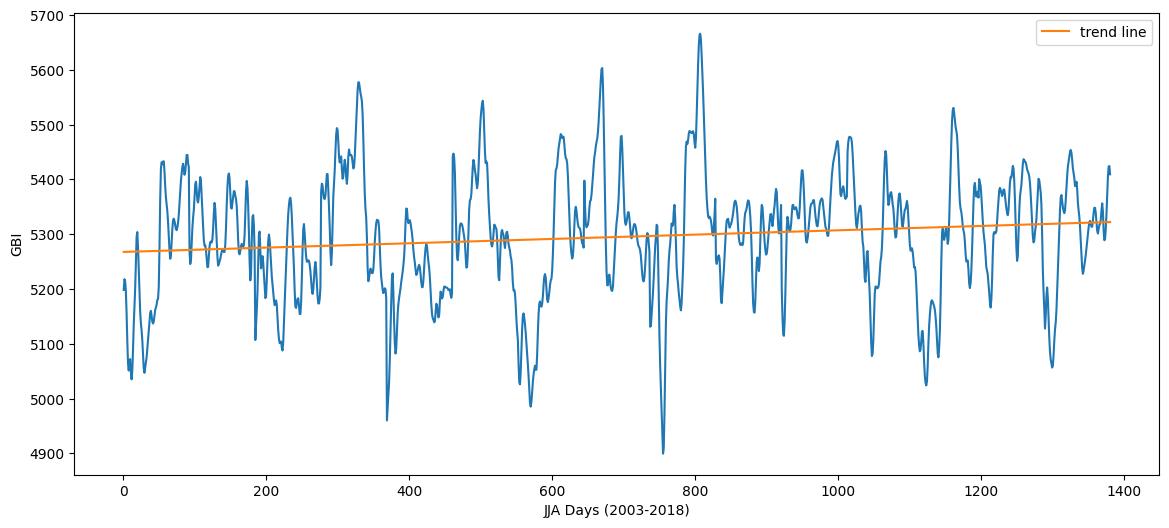

In [ ]:
plt.rcParams["figure.figsize"] = (14,6)
plt.plot(X, Y)
plt.xlabel('JJA Days (2003-2018)')
plt.ylabel('GBI')
plt.plot(X, lr.predict(X.reshape(-1,1)), label='trend line')
plt.legend()

## Seasonal Trend Analysis

### JJA Trend for 40 Years' Summer Data

In [ ]:
#Plotting just one year of data
import pandas as pd
gbi_daily = np.array(pd.read_csv('/content/drive/MyDrive/UMBC/iHARP/Data/GBI_daily_1979_2018.csv'))

j = 0
summer_days = gbi_daily[151:243,:]
print(summer_days.shape)
for i in range(1979,2018):
  if i % 4 == 0:
    year_data = gbi_daily[j:j+366,:]
    summer = year_data[152:244,:]
    summer_days = np.concatenate((summer_days,summer),axis = 0)
    j = j + 366
    #print(summer.shape)
    #print(summer_days.shape)
  else:
    year_data = gbi_daily[j:j+365,:]
    summer = year_data[151:243,:]
    summer_days = np.concatenate((summer_days,summer),axis = 0)
    j = j + 365

summer_days = summer_days[92:,:]
print('39 year summer days:',summer_days.shape)

(92, 2)
39 year summer days: (3588, 2)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

X = np.arange(1,3589,1)
Y = summer_days[:,-1]
lr = LinearRegression()
fit = lr.fit(X.reshape(-1, 1), Y)

## coefficients of linear fit are:
b = fit.intercept_
m = fit.coef_

print("the equation of the linear fit is: ")
print('y= ', m, 'x + ', b)

# checking R^2
R_sqd = lr.score(X.reshape(-1, 1), Y.reshape(-1, 1))
print("lr confidence: ", R_sqd)

the equation of the linear fit is: 
y=  [0.0041766] x +  5274.509333152316
lr confidence:  0.0013545278424172968


Plotting Trend

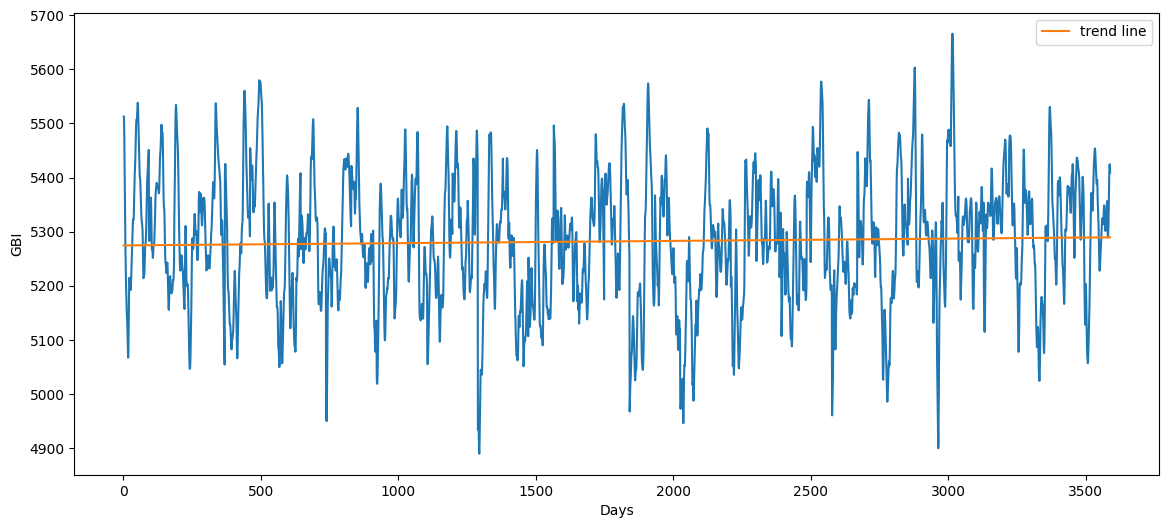

In [ ]:
plt.rcParams["figure.figsize"] = (14,6)
plt.plot(X, Y)
plt.xlabel('Days')
plt.ylabel('GBI')
plt.plot(X, lr.predict(X.reshape(-1,1)), label='trend line')
plt.legend()

### Trend for 40-year Averaged data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

gbi_daily_avg = np.array(pd.read_csv('/content/drive/MyDrive/UMBC/iHARP/Data/GBI_daily_mean_1979_2018.csv'))

X = np.arange(1,366,1)
Y = gbi_daily_avg
lr = LinearRegression()
fit = lr.fit(X.reshape(-1, 1), Y)

## coefficients of linear fit are:
b = fit.intercept_
m = fit.coef_

print("the equation of the linear fit is: ")
print('y= ', m, 'x + ', b)

# checking R^2
R_sqd = lr.score(X.reshape(-1, 1), Y.reshape(-1, 1))
print("lr confidence: ", R_sqd)

the equation of the linear fit is: 
y=  [[0.02924839]] x +  [5288.20249493]
lr confidence:  0.033791957037288434


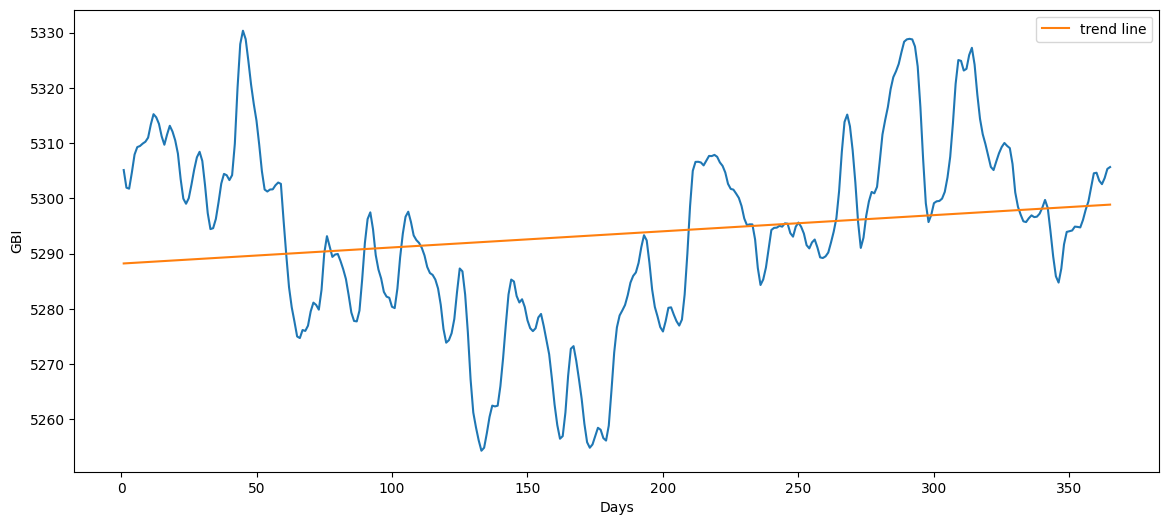

In [ ]:
# To show the relationship of the training set and the predicted prices.. we plot the following.
plt.rcParams["figure.figsize"] = (14,6)
plt.plot(X, Y)
plt.xlabel('Days')
plt.ylabel('GBI')
plt.plot(X, lr.predict(X.reshape(-1,1)), label='trend line')
plt.legend()

### JJA Trend for 40-years averaged Summer Data


In [ ]:
X = np.arange(1,93,1)
Y = gbi_daily_avg[151:243]
lr = LinearRegression()
fit = lr.fit(X.reshape(-1, 1), Y)

## coefficients of linear fit are:
b = fit.intercept_
m = fit.coef_

print("the equation of the linear fit is: ")
print('y= ', m, 'x + ', b)

# checking R^2
R_sqd = lr.score(X.reshape(-1, 1), Y.reshape(-1, 1))
print("lr confidence: ", R_sqd)

the equation of the linear fit is: 
y=  [[0.45428812]] x +  [5261.76843967]
lr confidence:  0.5735552936465255


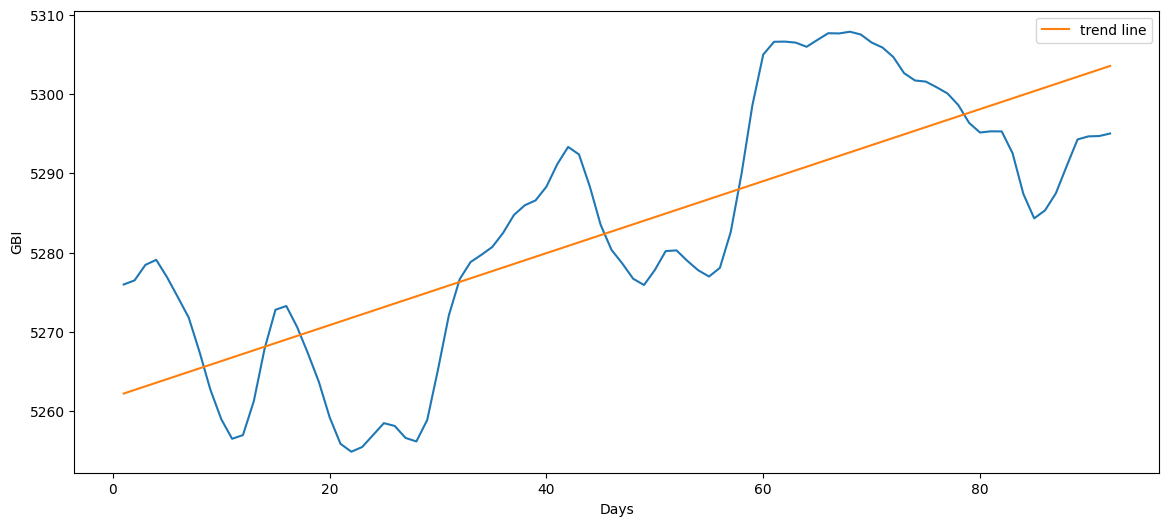

In [ ]:
# To show the relationship of the training set and the predicted prices.. we plot the following.
plt.rcParams["figure.figsize"] = (14,6)
plt.plot(X, Y)
plt.xlabel('Days')
plt.ylabel('GBI')
plt.plot(X, lr.predict(X.reshape(-1,1)), label='trend line')
plt.legend()

### Monthly Trend

In [ ]:
import pandas as pd
import numpy as np
monthly_gbi = np.array(pd.read_csv('/content/drive/MyDrive/UMBC/iHARP/Data/Greenland_domain_mean_1979_2021_monthly.csv'))

monthly_gbi = monthly_gbi[:,-1]
print(monthly_gbi.shape)
june_gbi = monthly_gbi[5::12]
july_gbi = monthly_gbi[6::12]
aug_gbi = monthly_gbi[7::12]
print(june_gbi.shape)
print(july_gbi.shape)
print(aug_gbi.shape)
summer_gbi = np.concatenate((june_gbi.reshape(-1,1),july_gbi.reshape(-1,1),aug_gbi.reshape(-1,1)),1)
#print(june_gbi[0],july_gbi[0],aug_gbi[0],summer_gbi[0],summer_gbi[42],summer_gbi[84])
mean_summer = np.mean((summer_gbi),axis=1)
print(mean_summer.shape)
print(summer_gbi.shape)

(504,)
(42,)
(42,)
(42,)
(42,)
(42, 3)


In [ ]:
#Reshape JJA months to reorder them for JJA for every year
summer_gbi_v2 = np.reshape(summer_gbi,126)
print(summer_gbi_v2.shape)
print(june_gbi[0],july_gbi[0],aug_gbi[0],summer_gbi_v2[0],summer_gbi_v2[1],summer_gbi_v2[2])

(126,)
5229.354887566666 5421.2250711612905 5320.1457623225815 5229.354887566666 5421.2250711612905 5320.1457623225815


(504, 5)


Text(0, 0.5, 'Greenland Blocking Index')

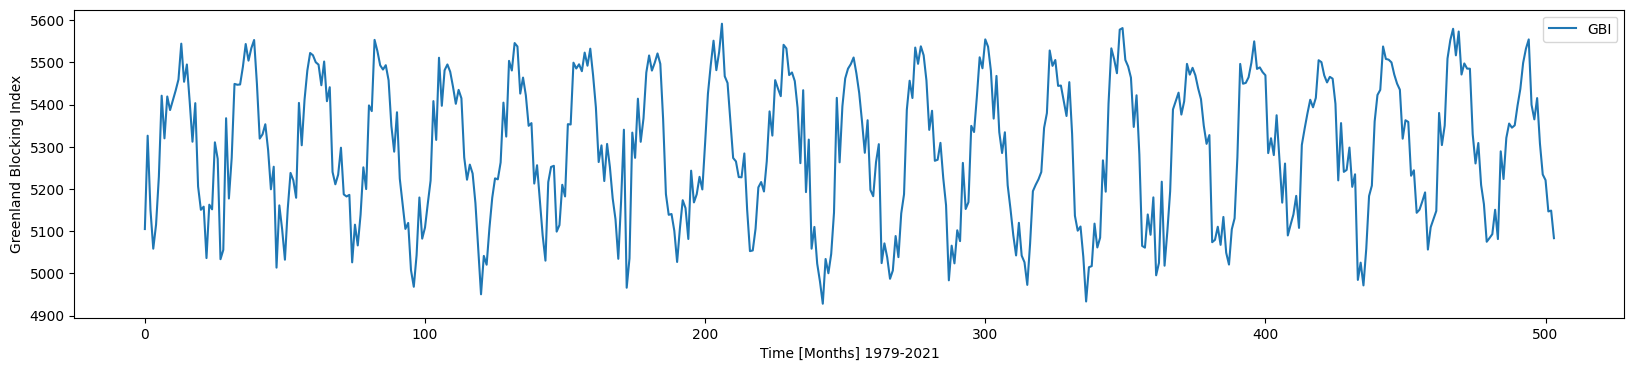

In [ ]:
import pandas as pd
import numpy as np
monthly_gbi = np.array(pd.read_csv('/content/drive/MyDrive/UMBC/iHARP/Data/Greenland_domain_mean_1979_2021_monthly.csv'))
print(monthly_gbi.shape)
import matplotlib.pyplot as plt
import datetime

fig,ax = plt.subplots(figsize = [20,4])
ax.plot(range(504),monthly_gbi[:,-1], label = "GBI")
ax.legend()
ax.set_xlabel("Time [Months] 1979-2021")
ax.set_ylabel(r"Greenland Blocking Index")

Text(0, 0.5, 'Mean JJA Greenland Blocking Index')

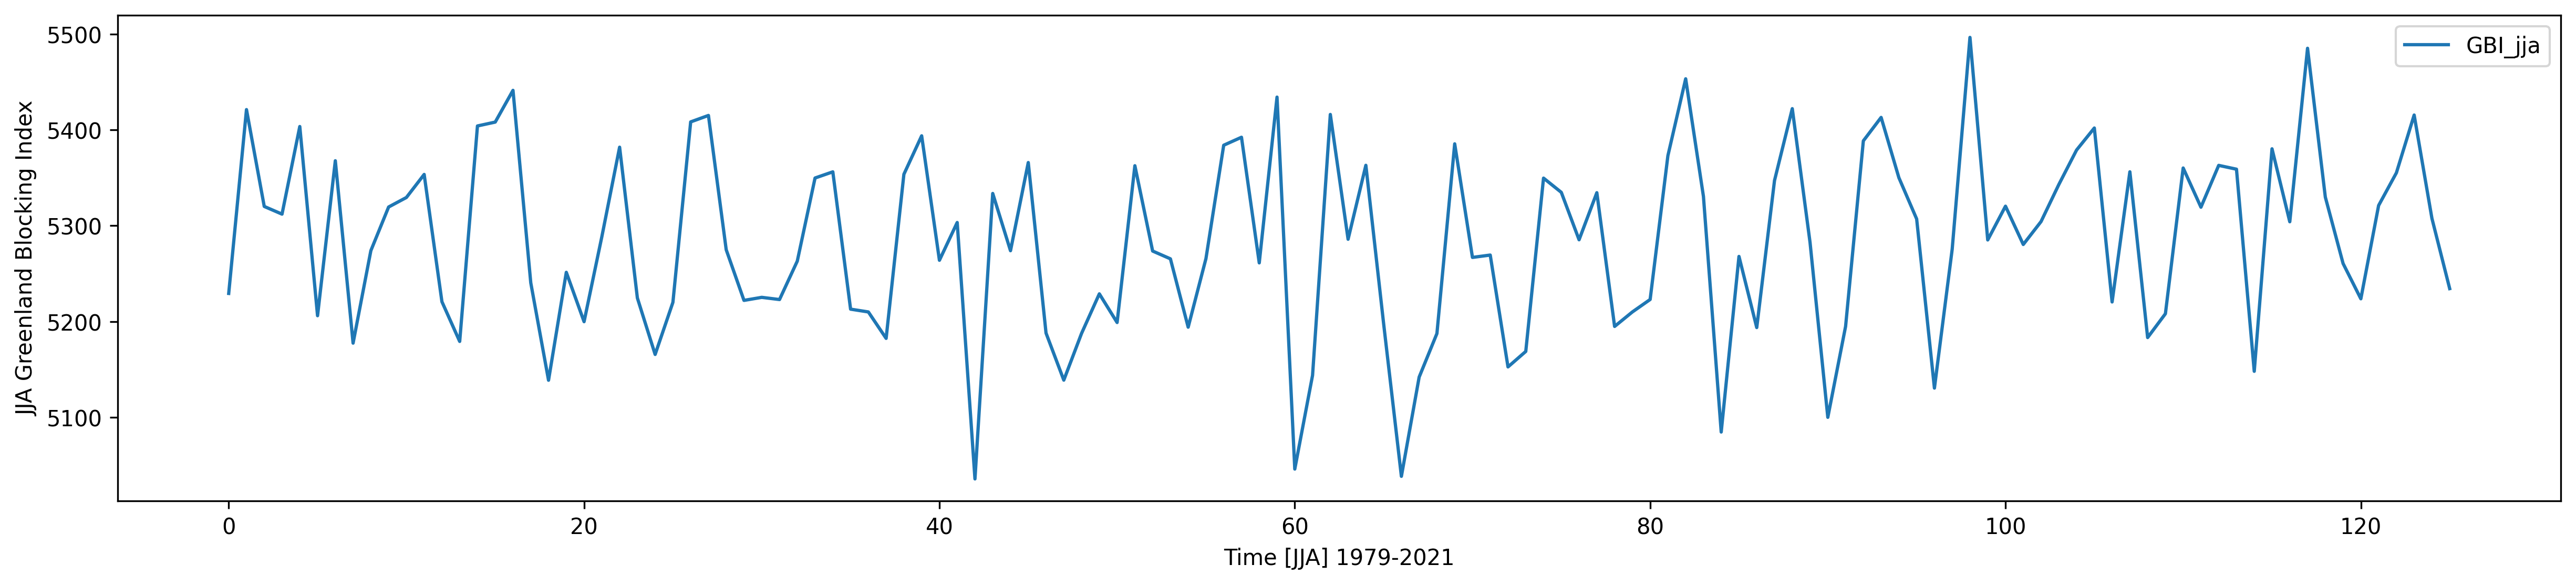

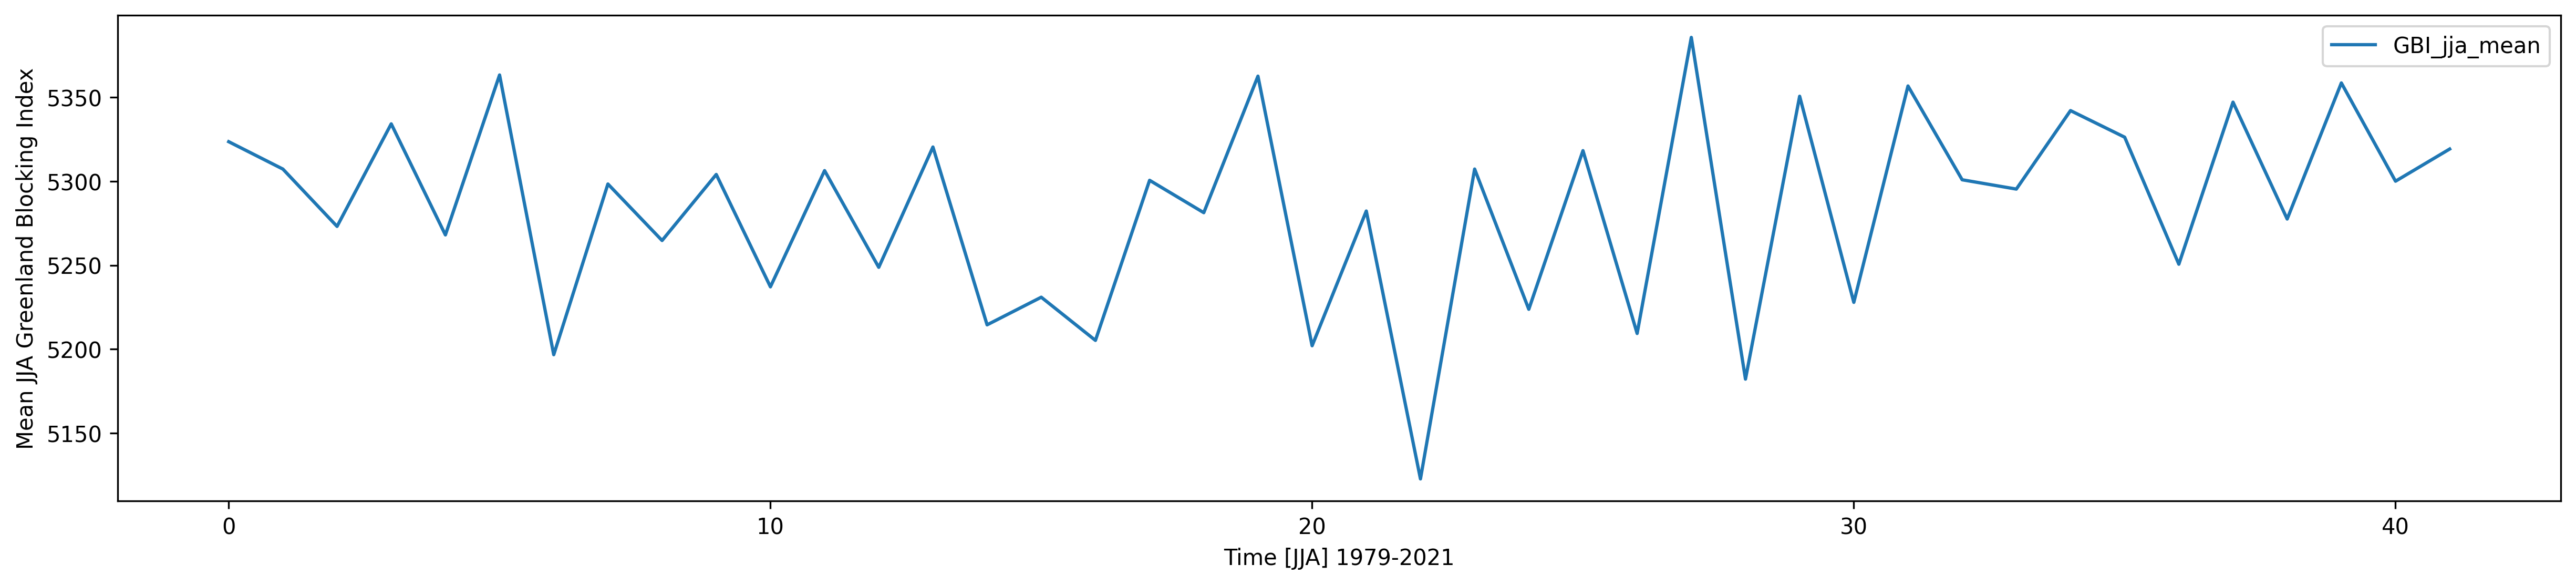

In [ ]:
import matplotlib.pyplot as plt
import datetime

fig,ax = plt.subplots(figsize = [20,4], dpi = 300)
ax.plot(range(126),summer_gbi_v2, label = "GBI_jja")
#ax.plot(range(42),mean_summer, label = "GBI_jja_mean")
ax.legend()
ax.set_xlabel("Time [JJA] 1979-2021")
ax.set_ylabel(r"JJA Greenland Blocking Index")

import matplotlib.pyplot as plt
import datetime

fig,ax = plt.subplots(figsize = [20,4], dpi = 300)
#ax.plot(range(126),summer_gbi_v2, label = "GBI_jja")
ax.plot(range(42),mean_summer, label = "GBI_jja_mean")
ax.legend()
ax.set_xlabel("Time [JJA] 1979-2021")
ax.set_ylabel(r"Mean JJA Greenland Blocking Index")

### GBI Summer Trend Analysis


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

X = np.arange(1,43,1)
Y = mean_summer.reshape(-1,1)
lr = LinearRegression()
fit = lr.fit(X.reshape(-1, 1), Y)

## coefficients of linear fit are:
b = fit.intercept_
m = fit.coef_

print("the equation of the linear fit is: ")
print('y= ', m, 'x + ', b)

# checking R^2
R_sqd = lr.score(X.reshape(-1, 1), Y.reshape(-1, 1))
print("lr confidence: ", R_sqd)

the equation of the linear fit is: 
y=  [[0.65656418]] x +  [5269.86601066]
lr confidence:  0.01892401883966277


Plotting the Trend

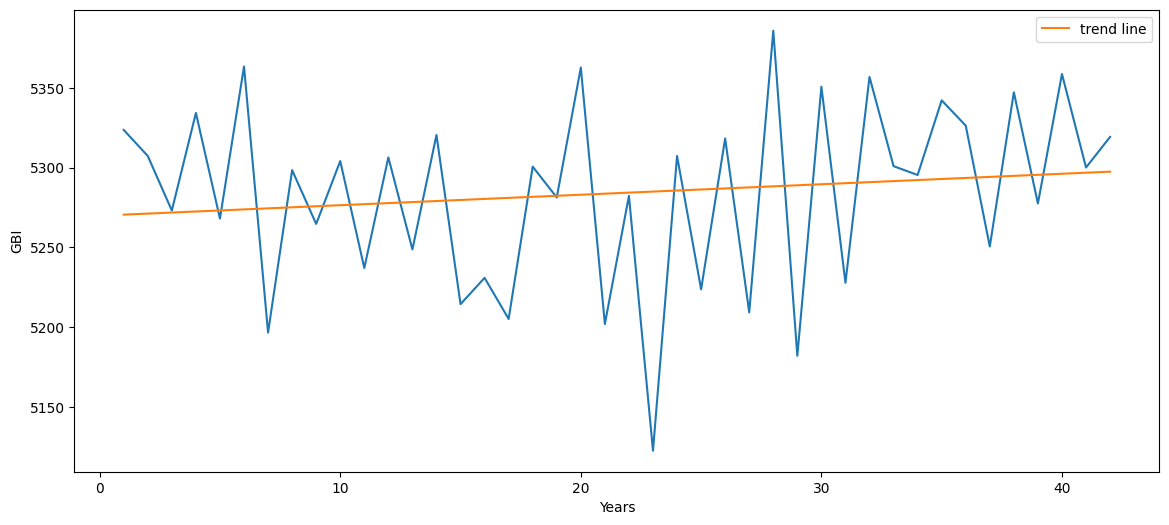

In [ ]:
# To show the relationship of the training set and the predicted prices.. we plot the following.
plt.rcParams["figure.figsize"] = (14,6)
plt.plot(X, Y)
plt.xlabel('Years')
plt.ylabel('GBI')
plt.plot(X, lr.predict(X.reshape(-1,1)), label='trend line')
plt.legend()

In [ ]:
print(summer_gbi_v2.shape)
print(mean_summer.shape)

mean_summer_2018 = mean_summer[:-3]
print(mean_summer_2018.shape)

mean_summer_gbi_2018 = summer_gbi_v2[:-9]
print(mean_summer_gbi_2018.shape)

jja_avg_mean = np.mean(mean_summer_2018)
jja_avg_min = np.min(mean_summer_2018)
jja_avg_max = np.max(mean_summer_2018)
jja_avg_std = np.std(mean_summer_2018)

jja_mean = np.mean(mean_summer_gbi_2018)
jja_min = np.min(mean_summer_gbi_2018)
jja_max = np.max(mean_summer_gbi_2018)
jja_std = np.std(mean_summer_gbi_2018)

print(jja_mean)
print(jja_min)
print(jja_max)
print(jja_std)

print(jja_avg_mean)
print(jja_avg_min)
print(jja_avg_max)
print(jja_avg_std)

(126,)
(42,)
(39,)
(117,)
5280.75429031509
5035.758178433333
5496.576857548387
96.66297057484627
5280.754290315092
5122.671893044087
5385.706225360214
58.41713218171592


### GBI Winter Trend Analysis

In [ ]:
import pandas as pd
import numpy as np
monthly_gbi = np.array(pd.read_csv('/content/drive/MyDrive/UMBC/iHARP/Data/Greenland_domain_mean_1979_2021_monthly.csv'))

monthly_gbi = monthly_gbi[:,-1]
print(monthly_gbi.shape)
jan_gbi = monthly_gbi[0::12]
feb_gbi = monthly_gbi[1::12]
dec_gbi = monthly_gbi[11::12]

print(dec_gbi.shape)
print(jan_gbi.shape)
print(feb_gbi.shape)

#dec_gbi = dec_gbi[:-1]

#winter_gbi = np.concatenate((dec_gbi.reshape(-1,1),jan_gbi.reshape(-1,1),feb_gbi.reshape(-1,1)),1)
winter_gbi = np.concatenate((jan_gbi.reshape(-1,1),feb_gbi.reshape(-1,1),dec_gbi.reshape(-1,1)),1)

mean_winter = np.mean((winter_gbi),axis=1)
print(mean_winter.shape)
print(winter_gbi.shape)

#Reshape DJF months to reorder them for DFJ for every year
winter_gbi = np.reshape(winter_gbi,126)
print(winter_gbi.shape)
#print(dec_gbi[0],jan_gbi[0],feb_gbi[0],winter_gbi[0],winter_gbi[1],winter_gbi[2])
print(jan_gbi[0],feb_gbi[0],dec_gbi[0],winter_gbi[0],winter_gbi[1],winter_gbi[2])

(504,)
(42,)
(42,)
(42,)
(42,)
(42, 3)
(126,)
5105.075605096775 5326.400299535715 5433.578738064517 5105.075605096775 5326.400299535715 5433.578738064517


In [ ]:
print(dec_gbi[0:5],jan_gbi[0:5],feb_gbi[0:5])

print(winter_gbi[:10])

[5433.57873806 5162.84223687 5489.8871201  5013.62769794 5522.47316145] [5105.0756051  5459.76117452 5151.81580729 5543.74924984 5161.21971755] [5326.40029954 5544.59389341 5310.66737504 5504.32855075 5104.87961975]
[5105.0756051  5326.40029954 5433.57873806 5459.76117452 5544.59389341
 5162.84223687 5151.81580729 5310.66737504 5489.8871201  5543.74924984]


Text(0, 0.5, 'Mean JFD Greenland Blocking Index')

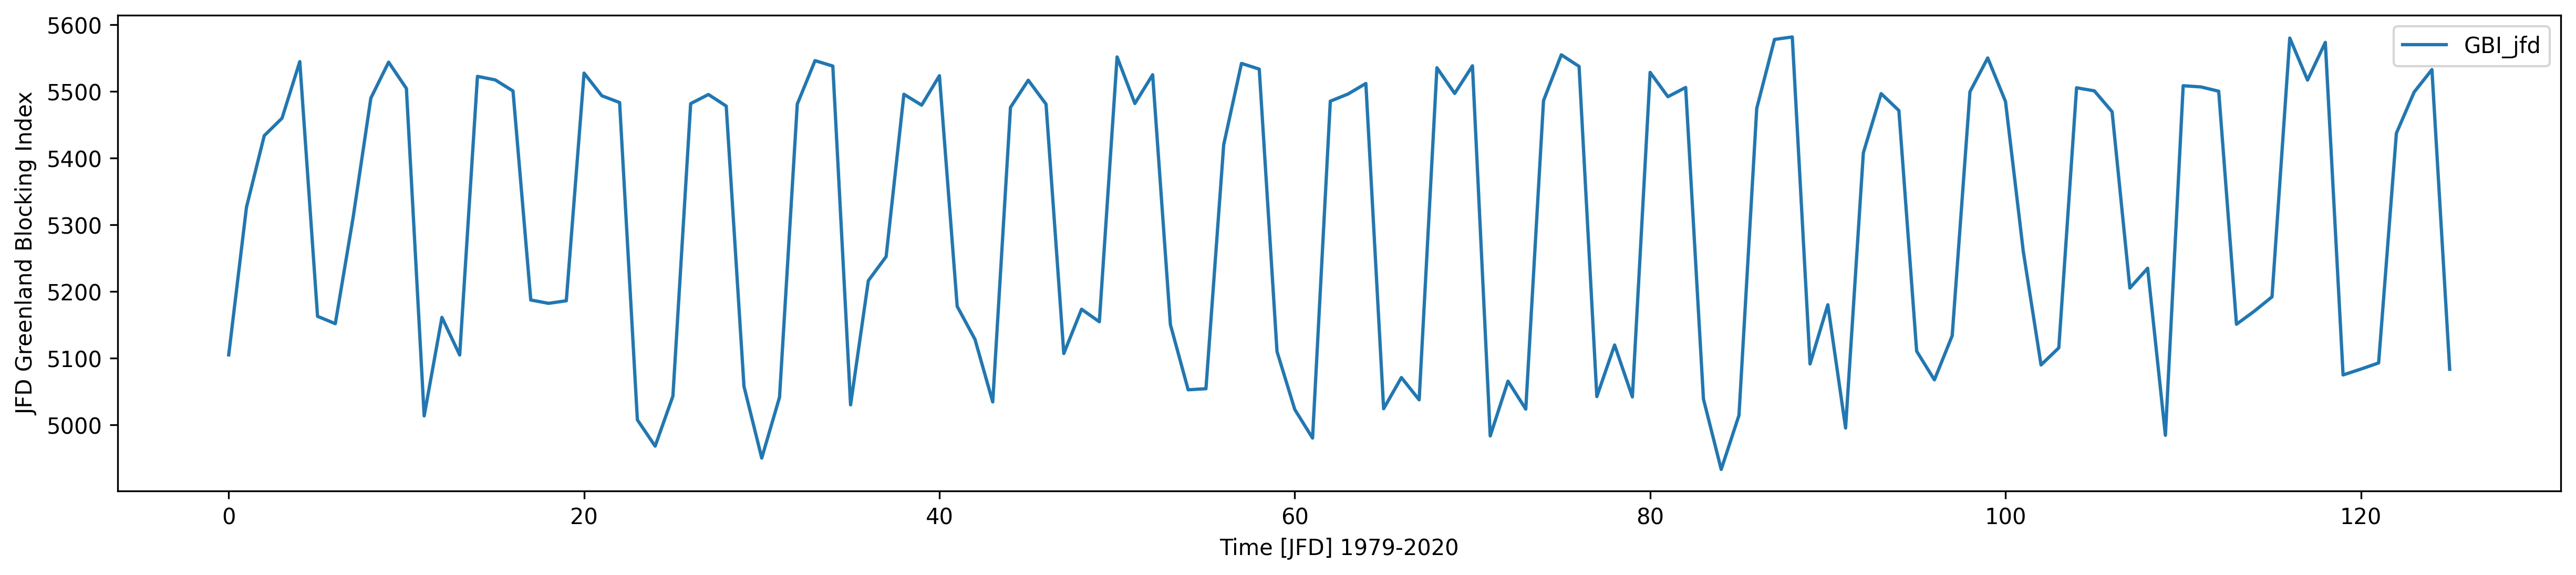

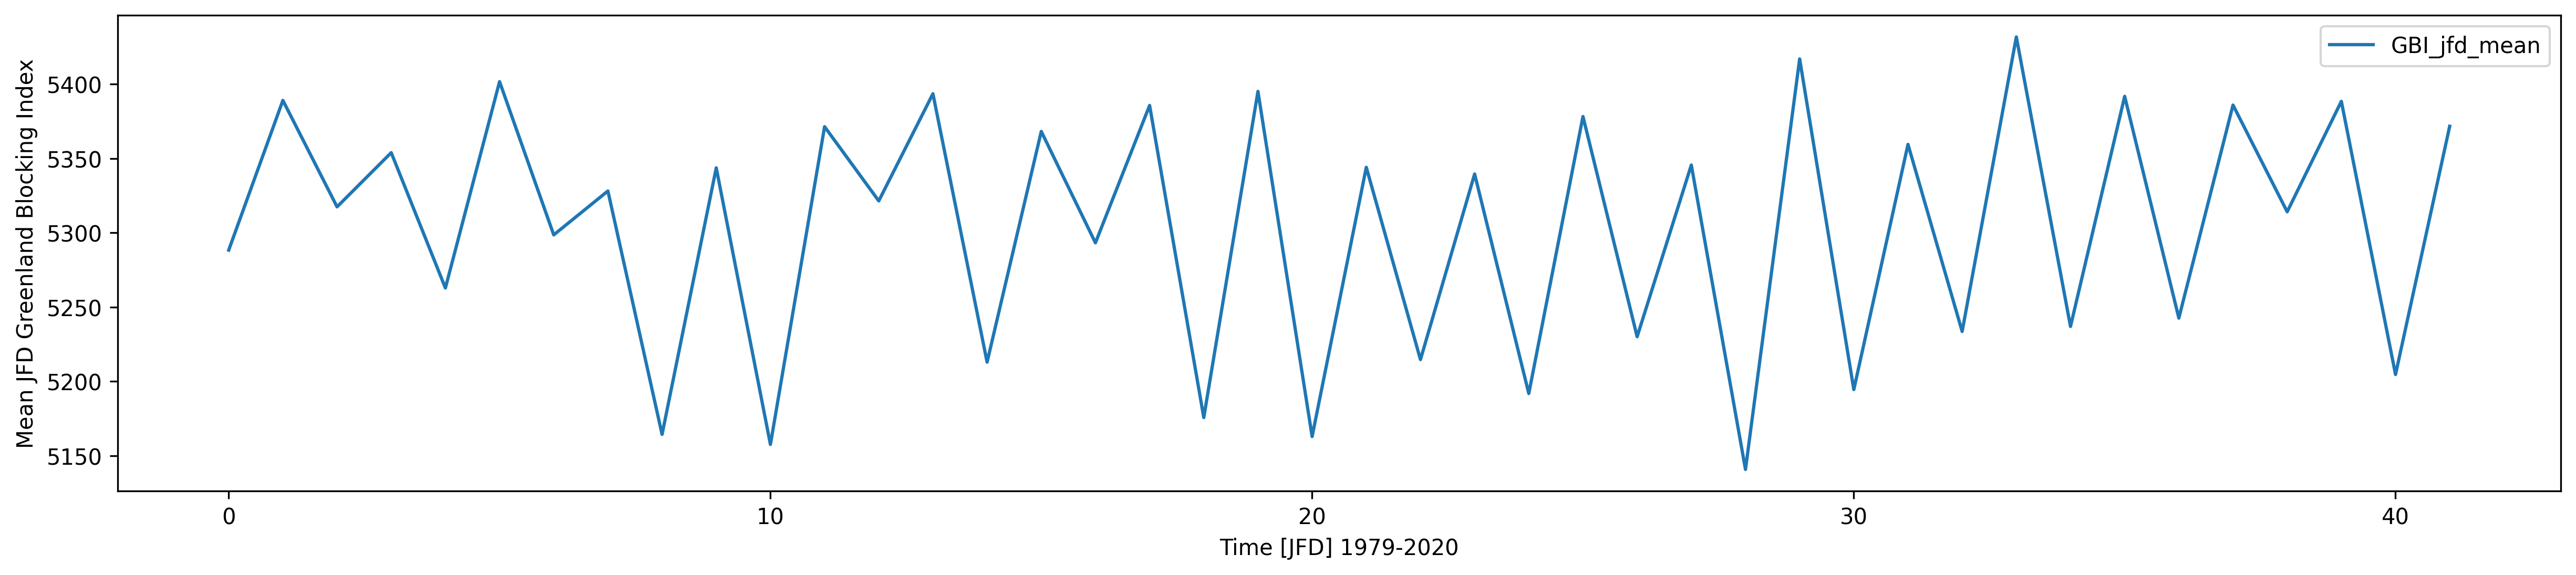

In [ ]:
import matplotlib.pyplot as plt
import datetime

fig,ax = plt.subplots(figsize = [20,4], dpi = 300)
ax.plot(range(126),winter_gbi, label = "GBI_jfd")
ax.legend()
ax.set_xlabel("Time [JFD] 1979-2020")
ax.set_ylabel(r"JFD Greenland Blocking Index")

import matplotlib.pyplot as plt
import datetime

fig,ax = plt.subplots(figsize = [20,4], dpi = 300)
ax.plot(range(42),mean_winter, label = "GBI_jfd_mean")
ax.legend()
ax.set_xlabel("Time [JFD] 1979-2020")
ax.set_ylabel(r"Mean JFD Greenland Blocking Index")

#Todo

### GBI vs SIE Lagged Correlation

In [ ]:
import numpy as np
import pandas as pd
from scipy import signal
rng = np.random.default_rng()
x = rng.standard_normal(1000)
y = np.concatenate([rng.standard_normal(100), x])
correlation = signal.correlate(x, y, mode="full")
lags = signal.correlation_lags(x.size, y.size, mode="full")
lag = lags[np.argmax(correlation)]
print(lags)
print(lag)

[-1099 -1098 -1097 ...   997   998   999]
-100


In [ ]:
df = pd.read_csv('/content/Arctic_SIE_GBI_1979_2018.csv')
df = df.drop(columns=['Date'],axis = 1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14610 entries, 0 to 14609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GBI     14610 non-null  float64
 1   SIE     14610 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 228.4 KB
None


In [ ]:
#Find max lagged correlation in SIE and GBI (by adding lag to GBI)
max_lag = 31
lagged_correlation = pd.DataFrame.from_dict(
    {x: [df['SIE'].corr(df[x].shift(-t)) for t in range(max_lag)] for x in df.columns})

In [ ]:
print(lagged_correlation['GBI'])

In [ ]:
#Find max lagged correlation in SIE and GBI (by adding lag to SIE)
max_lag = 31
lagged_correlation = pd.DataFrame.from_dict(
    {x: [df['GBI'].corr(df[x].shift(-t)) for t in range(max_lag)] for x in df.columns})

print(lagged_correlation)

In [ ]:
#Normalize Data - Comment out this cell if not normalizing the data
import pandas as pd
from sklearn import preprocessing

data = np.array(df)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(data)
df2 = pd.DataFrame(x_scaled)
df2.columns = ['GBI','SIE']
print(df2.head())

        GBI       SIE
0  0.471689  0.876826
1  0.446416  0.876826
2  0.457105  0.876826
3  0.468611  0.871185
4  0.464837  0.871185


In [ ]:
#Find max lagged correlation in SIE and GBI (by adding lag to GBI)
max_lag = 31
lagged_correlation = pd.DataFrame.from_dict(
    {x: [df2['SIE'].corr(df2[x].shift(-t)) for t in range(max_lag)] for x in df2.columns})

print(lagged_correlation['GBI'])

In [ ]:
df = pd.read_csv('/content/Arctic_regional_SIE_GBI.csv')
df = df.drop(columns=['Date'],axis = 1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14610 entries, 0 to 14609
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GBI           14610 non-null  float64
 1   Baffin_sie    14610 non-null  int64  
 2   BarKara_sie   14610 non-null  int64  
 3   Bering_sie    14610 non-null  int64  
 4   CanArch_sie   14610 non-null  int64  
 5   Grnland_sie   14610 non-null  int64  
 6   Okhotsk_sie   14610 non-null  int64  
 7   StLawr_sie    14610 non-null  int64  
 8   Hudson_sie    14610 non-null  int64  
 9   ArOc_sie      14610 non-null  int64  
 10  Ar_whole_sie  14610 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 1.2 MB
None


In [ ]:
#Find max lagged correlation in regional SIE and GBI (by adding lag to GBI)
max_lag = 31
lagged_correlation = pd.DataFrame.from_dict(
    {x: [df[x].corr(df['GBI'].shift(-t)) for t in range(max_lag)] for x in df.columns})

print(lagged_correlation)

### Seasonal Data Lagged Correlation
May - Oct 1979 - 2018


In [ ]:
df = pd.read_csv('/content/Arctic_regional_SIE_GBI_May_Oct.csv')
df = df.drop(columns=['Date'],axis = 1)
print(df.info())

In [ ]:
#Find max lagged correlation in regional SIE and GBI (by adding lag to GBI)
max_lag = 40
lagged_correlation = pd.DataFrame.from_dict(
    {x: [df[x].corr(df['GBI'].shift(-t)) for t in range(max_lag)] for x in df.columns})

print(lagged_correlation)

## Greenland Melt Extent Dataset

In [ ]:
import numpy as np
import pandas as pd

melt_data = np.load("/content/RunningAvg-Melt-extent-1979-2022.npy")

In [ ]:
melt_data.shape

(9240,)

In [ ]:
dict={'melt_extent_avg':melt_data}
data=pd.DataFrame(dict)
data.to_csv('/content/Melt_extent_running_avg_1979_2022.csv',header=True,index=False)

## Shapefile Reading

In [ ]:
import geopandas as gp

In [ ]:
import geopandas as gpd

# Set filepath
fp = "/content/all_subregions.shp"

# Read file using gpd.read_file()
data = gpd.read_file(fp)

<Axes: >

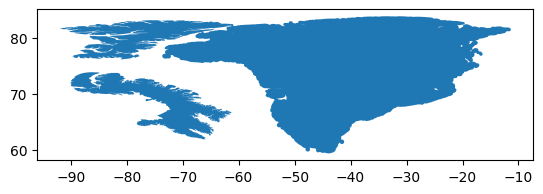

In [ ]:
%matplotlib inline
data.plot()

In [ ]:
import xarray as xr
import geopandas as gp
import regionmask

In [ ]:
### ----- Read ERA5 data ----- ###
GrIS_shp = gp.read_file('all_subregions.shp')
era5_GrIS_basin_mask = regionmask.mask_geopandas(GrIS_shp['geometry'][2:], era5_lon, era5_lat)
#era5_GrIS_mask = xr.where(era5_GrIS_basin_mask>0, 1, 0)#.values

NameError: ignored